# System Morphology
Here we probe the morphological differences between extreme and non-extreme PFs.

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from global_land_mask import globe
from scipy.stats import binned_statistic, binned_statistic_2d
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from src.regions import *
from src.pf_stats import *
from src.plotting import *

## PDF of PF sizes

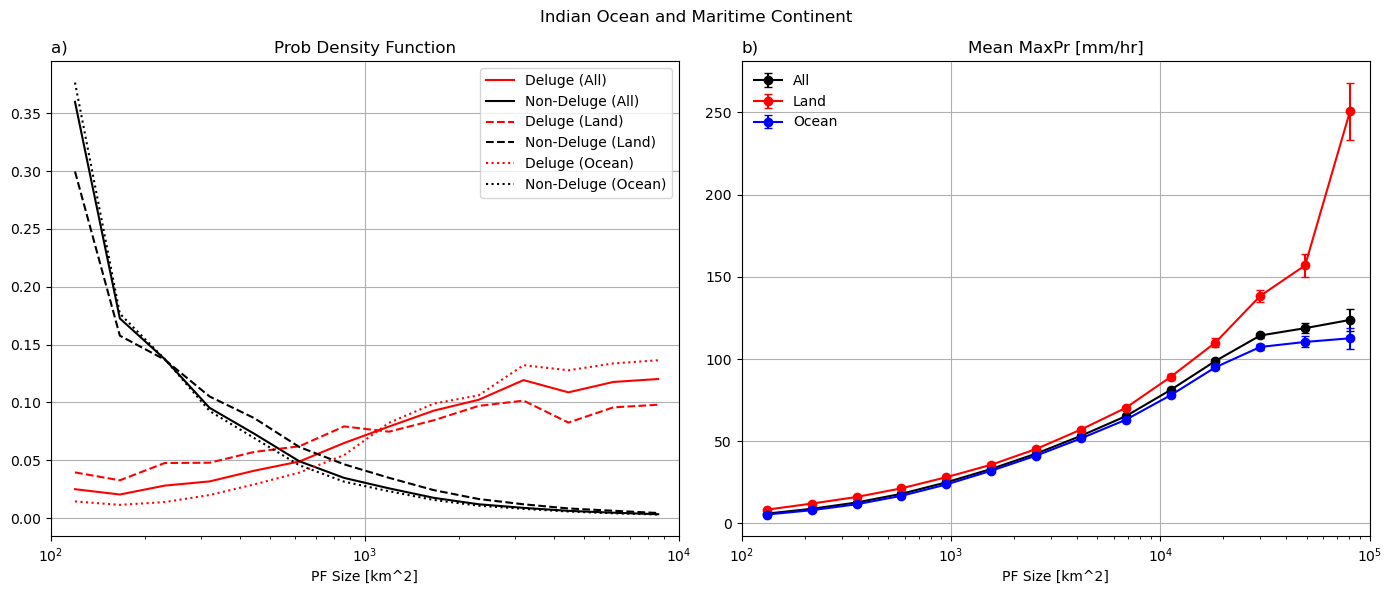

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6))
regions = [cio_region()]

ax = axs[0]
epe_size = np.array([])
non_epe_size = np.array([])

epe_size_land = np.array([])
epe_size_ocean = np.array([])

non_epe_size_land = np.array([])
non_epe_size_ocean = np.array([])

for region in regions:
    pf_stats = load_pf_stats(region, trim_region=True)
    size = pf_stats.num_pixels * 25
    max_pr = pf_stats.max_precip
    lat = pf_stats.mean_latitude
    lon = pf_stats.mean_longitude

    # Determine which PFs are on land/ocean
    land_mask = globe.is_land(lat=lat, lon=lon) == 1
    ocean_mask = ~land_mask

    # Determine which PFs are EPE (deluge)
    epe_id = (max_pr >= 100)
    non_epe_id = ~epe_id

    # Separate EPE and non-EPE sizes
    # Convert xarray DataArrays or pandas Series to numpy arrays if needed by using .values
    # Assuming 'size' is a DataArray or Series, you can do size.values. If it's already a numpy array, skip that.
    size_arr = size.values if hasattr(size, 'values') else size

    # EPE sizes
    epe_size = np.concatenate((epe_size, size_arr[epe_id]))
    non_epe_size = np.concatenate((non_epe_size, size_arr[non_epe_id]))

    # Separate by land/ocean as well
    epe_size_land = np.concatenate((epe_size_land, size_arr[epe_id & land_mask]))
    epe_size_ocean = np.concatenate((epe_size_ocean, size_arr[epe_id & ocean_mask]))

    non_epe_size_land = np.concatenate((non_epe_size_land, size_arr[non_epe_id & land_mask]))
    non_epe_size_ocean = np.concatenate((non_epe_size_ocean, size_arr[non_epe_id & ocean_mask]))

size_bins = np.logspace(2, 4, 15)
x_midpoints = array_midpoints(size_bins)

# Compute binned counts for all EPE and non-EPE
epe_binned_count = binned_statistic(epe_size, None, statistic='count', bins=size_bins).statistic
non_epe_binned_count = binned_statistic(non_epe_size, None, statistic='count', bins=size_bins).statistic

# Compute binned counts for land vs ocean, EPE and non-EPE
epe_land_binned_count = binned_statistic(epe_size_land, None, statistic='count', bins=size_bins).statistic
epe_ocean_binned_count = binned_statistic(epe_size_ocean, None, statistic='count', bins=size_bins).statistic

non_epe_land_binned_count = binned_statistic(non_epe_size_land, None, statistic='count', bins=size_bins).statistic
non_epe_ocean_binned_count = binned_statistic(non_epe_size_ocean, None, statistic='count', bins=size_bins).statistic

# Plot all data
ax.plot(x_midpoints, epe_binned_count / epe_binned_count.sum(), label='Deluge (All)', color='red', linestyle='-')
ax.plot(x_midpoints, non_epe_binned_count / non_epe_binned_count.sum(), label='Non-Deluge (All)', color='black', linestyle='-')

# Plot land-only data
ax.plot(x_midpoints, epe_land_binned_count / epe_land_binned_count.sum(), label='Deluge (Land)', color='red', linestyle='--')
ax.plot(x_midpoints, non_epe_land_binned_count / non_epe_land_binned_count.sum(), label='Non-Deluge (Land)', color='black', linestyle='--')

# Plot ocean-only data
ax.plot(x_midpoints, epe_ocean_binned_count / epe_ocean_binned_count.sum(), label='Deluge (Ocean)', color='red', linestyle=':')
ax.plot(x_midpoints, non_epe_ocean_binned_count / non_epe_ocean_binned_count.sum(), label='Non-Deluge (Ocean)', color='black', linestyle=':')

ax.set_xlabel('PF Size [km^2]')
ax.set_title('Prob Density Function')
ax.set_title('a)', loc='left')

ax.set_xscale('log')
ax.set_xlim(size_bins.min(), size_bins.max())
ax.grid()

ax.legend(loc='upper right', frameon=True, facecolor='white')


#####################
ax = axs[1]
# Define your regions

size = np.array([])
max_pr = np.array([])
is_land = np.array([])

# Load and concatenate data for all regions
for region in regions:
    pf_stats = load_pf_stats(region, trim_region=True)
    # Calculate size in km^2 (assuming each pixel is 25 km^2)
    size = np.concatenate((size, pf_stats.num_pixels * 25))
    max_pr = np.concatenate((max_pr, pf_stats.max_precip))

    lat = pf_stats.mean_latitude
    lon = pf_stats.mean_longitude
    # Make sure to pass the new arrays as a tuple to np.concatenate
    is_land = np.concatenate((is_land, globe.is_land(lat=lat, lon=lon)))

# Define your bins
size_bins = np.logspace(2, 5, 15)
x_bins = size_bins

# Separate the data by land and ocean
land_mask = (is_land == 1)
ocean_mask = (is_land == 0)

# Compute statistics for all data
binned_stat_all = binned_statistic(size, max_pr, statistic=lambda x: np.nanmean(x), bins=x_bins).statistic
binned_std_all = binned_statistic(size, max_pr, statistic=lambda x: np.nanstd(x), bins=x_bins).statistic
binned_count_all = binned_statistic(size, max_pr, statistic='count', bins=x_bins).statistic

# Compute statistics for land-only data
binned_stat_land = binned_statistic(size[land_mask], max_pr[land_mask], 
                                    statistic=lambda x: np.nanmean(x), bins=x_bins).statistic
binned_std_land = binned_statistic(size[land_mask], max_pr[land_mask], 
                                   statistic=lambda x: np.nanstd(x), bins=x_bins).statistic
binned_count_land = binned_statistic(size[land_mask], max_pr[land_mask], 
                                     statistic='count', bins=x_bins).statistic

# Compute statistics for ocean-only data
binned_stat_ocean = binned_statistic(size[ocean_mask], max_pr[ocean_mask], 
                                     statistic=lambda x: np.nanmean(x), bins=x_bins).statistic
binned_std_ocean = binned_statistic(size[ocean_mask], max_pr[ocean_mask], 
                                    statistic=lambda x: np.nanstd(x), bins=x_bins).statistic
binned_count_ocean = binned_statistic(size[ocean_mask], max_pr[ocean_mask], 
                                      statistic='count', bins=x_bins).statistic

# Compute x midpoints for plotting
x_midpoints = array_midpoints(x_bins)

# Plotting
# Plot all data
ax.errorbar(x_midpoints, binned_stat_all, yerr=binned_std_all/np.sqrt(binned_count_all),
            marker='o', linestyle='-', capsize=3, color='black', label='All')
# Plot land data
ax.errorbar(x_midpoints, binned_stat_land, yerr=binned_std_land/np.sqrt(binned_count_land),
            marker='o', linestyle='-', capsize=3, color='red', label='Land')
# Plot ocean data
ax.errorbar(x_midpoints, binned_stat_ocean, yerr=binned_std_ocean/np.sqrt(binned_count_ocean),
            marker='o', linestyle='-', capsize=3, color='blue', label='Ocean')

ax.set_title('Mean MaxPr [mm/hr]')
ax.set_title('b)', loc='left')
ax.set_xlabel('PF Size [km^2]')
ax.legend(loc='upper left', frameon=False, facecolor='white')
ax.grid()
ax.set_xscale('log')
ax.set_xlim(x_bins.min(), x_bins.max())

fig.suptitle('Indian Ocean and Maritime Continent')
fig.tight_layout(pad=1)

## Comparing Morphological distributions

### Principal core size and precip

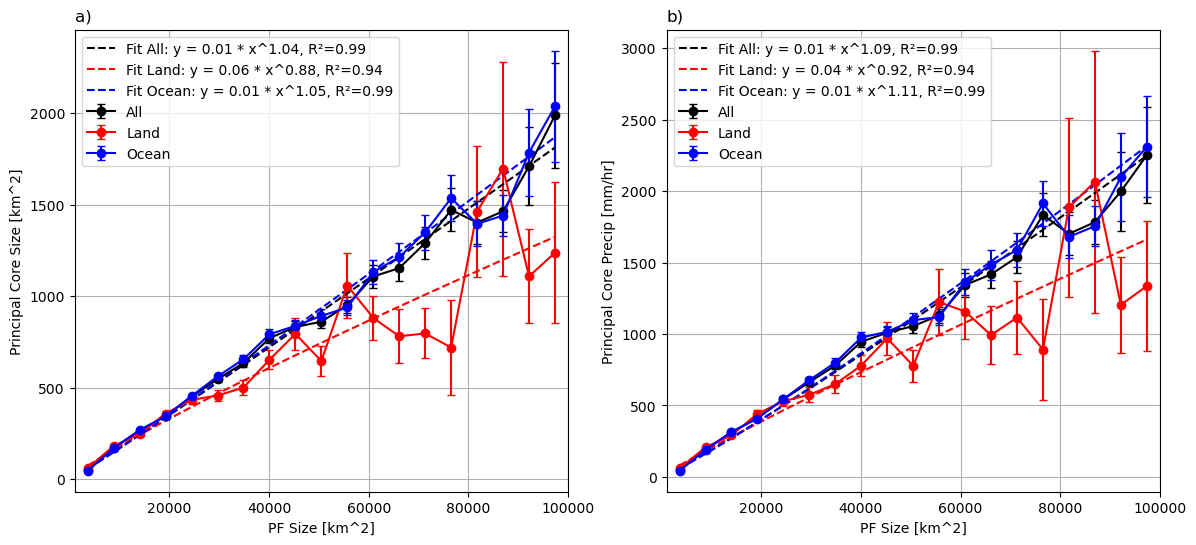

In [162]:
regions = [cio_region(), wmp_region()]

size = np.array([])
principal_core_size = np.array([])
principal_core_precip = np.array([])
max_pr = np.array([])
is_land = np.array([])

# Load and concatenate data for all regions
for region in regions:
    pf_stats = load_pf_stats(region, trim_region=True)
    # Calculate size in km^2 (assuming each pixel is 25 km^2)
    cur_size = pf_stats.num_pixels * 25
    cur_pcs = pf_stats.max_10mmhr_size * 25
    cur_pcpr = pf_stats.max_10mmhr_cluster_precip
    lat = pf_stats.mean_latitude
    lon = pf_stats.mean_longitude
    
    size = np.concatenate((size, cur_size))
    principal_core_size = np.concatenate((principal_core_size, cur_pcs))
    principal_core_precip = np.concatenate((principal_core_precip, cur_pcpr))
    is_land = np.concatenate((is_land, globe.is_land(lat=lat, lon=lon)))

# Create masks for land and ocean
land_mask = (is_land == 1)
ocean_mask = (is_land == 0)

# Define your bins
size_bins = np.logspace(3, 5, 50)
size_bins = np.linspace(1e3, 1e5, 20)

fig, axs = plt.subplots(ncols=2, figsize=(14,6))

for ax, stat in zip(axs.ravel(), [principal_core_size, principal_core_precip]):
    # Compute statistics for all data
    binned_mean_all = binned_statistic(size, stat, statistic=lambda x: np.nanmean(x), bins=size_bins).statistic
    binned_std_all = binned_statistic(size, stat, statistic=lambda x: np.nanstd(x), bins=size_bins).statistic
    binned_count_all = binned_statistic(size, stat, statistic='count', bins=size_bins).statistic

    # Compute statistics for land-only data
    binned_mean_land = binned_statistic(size[land_mask], stat[land_mask], statistic=lambda x: np.nanmean(x), bins=size_bins).statistic
    binned_std_land = binned_statistic(size[land_mask], stat[land_mask], statistic=lambda x: np.nanstd(x), bins=size_bins).statistic
    binned_count_land = binned_statistic(size[land_mask], stat[land_mask], statistic='count', bins=size_bins).statistic

    # Compute statistics for ocean-only data
    binned_mean_ocean = binned_statistic(size[ocean_mask], stat[ocean_mask], statistic=lambda x: np.nanmean(x), bins=size_bins).statistic
    binned_std_ocean = binned_statistic(size[ocean_mask], stat[ocean_mask], statistic=lambda x: np.nanstd(x), bins=size_bins).statistic
    binned_count_ocean = binned_statistic(size[ocean_mask], stat[ocean_mask], statistic='count', bins=size_bins).statistic

    # Compute x midpoints for plotting
    x_midpoints = array_midpoints(size_bins)

    # Compute standard errors
    se_all = binned_std_all / np.sqrt(binned_count_all)
    se_land = binned_std_land / np.sqrt(binned_count_land)
    se_ocean = binned_std_ocean / np.sqrt(binned_count_ocean)

    # Plot the data with error bars
    ax.errorbar(x_midpoints, binned_mean_all, yerr=se_all, color='black', linestyle='solid', label='All', capsize=3, marker='o')
    ax.errorbar(x_midpoints, binned_mean_land, yerr=se_land, color='red', linestyle='solid', label='Land', capsize=3, marker='o')
    ax.errorbar(x_midpoints, binned_mean_ocean, yerr=se_ocean, color='blue', linestyle='solid', label='Ocean', capsize=3, marker='o')

    ax.set_xscale('linear')
    ax.set_xlabel('PF Size [km^2]')

    ax.set_xlim(size_bins.min(), size_bins.max())
    ax.grid()
    ax.legend()

    # Function to fit and plot regression lines and R²
    def plot_log_log_regression(x, y, color, label_suffix):
        # Remove NaNs
        mask = ~np.isnan(y)
        if np.sum(mask) < 2:
            return  # Not enough points to fit
        x_valid = x[mask]
        y_valid = y[mask]
        
        # Convert to log10 space
        log_x = np.log10(x_valid)
        log_y = np.log10(y_valid)
        
        # Fit in log10 space
        slope, intercept = np.polyfit(log_x, log_y, 1)
        
        # Compute predictions and R² in log space
        log_y_pred = slope*log_x + intercept
        ss_res = np.sum((log_y - log_y_pred)**2)
        ss_tot = np.sum((log_y - np.mean(log_y))**2)
        r2 = 1 - ss_res/ss_tot
        
        # Generate a smooth line for plotting the fit
        x_fit = np.logspace(np.log10(x_valid.min()), np.log10(x_valid.max()), 100)
        y_fit = 10**(intercept + slope * np.log10(x_fit))
        
        # Format the equation and R²
        prefactor = 10**intercept
        equation_str = f'Fit {label_suffix}: y = {prefactor:.2f} * x^{slope:.2f}, R²={r2:.2f}'

        # Plot the fit line
        ax.plot(x_fit, y_fit, color=color, linestyle='--', label=equation_str)

    # Fit and plot regression lines for each dataset
    plot_log_log_regression(x_midpoints, binned_mean_all, 'black', 'All')
    plot_log_log_regression(x_midpoints, binned_mean_land, 'red', 'Land')
    plot_log_log_regression(x_midpoints, binned_mean_ocean, 'blue', 'Ocean')

    ax.legend()

axs[0].set_ylabel('Principal Core Size [km^2]')
axs[0].set_yscale('linear')
axs[0].set_title('a)', loc='left')

axs[1].set_ylabel('Principal Core Precip [mm/hr]')
axs[1].set_yscale('linear')
axs[1].set_title('b)', loc='left')

plt.show()


## Localization

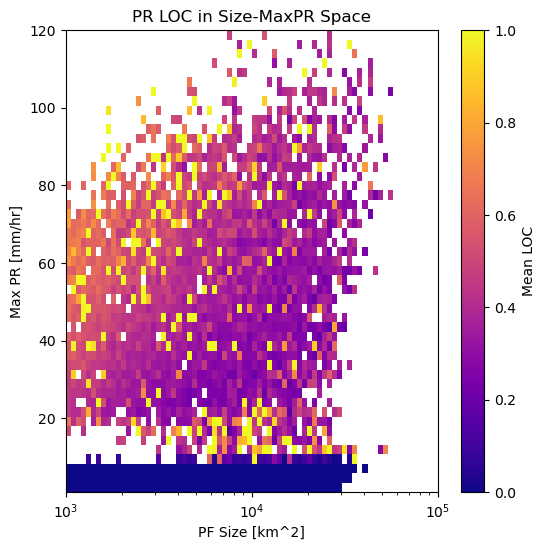

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d

regions = [cio_region(), wmp_region()]

size = np.array([])
loc = np.array([])
max_pr = np.array([])

# Load and concatenate data for all regions
for region in regions:
    pf_stats = load_pf_stats(region, trim_region=True)
    cur_size = pf_stats.num_pixels * 25
    cur_loc = (pf_stats.max_10mmhr_cluster_precip / pf_stats.total_conv_precip)#/(pf_stats.max_10mmhr_size/pf_stats.num_pixels)
    cur_max_pr = pf_stats.max_precip

    size = np.concatenate((size, cur_size))
    loc = np.concatenate((loc, cur_loc))
    max_pr = np.concatenate((max_pr, cur_max_pr))

fig, ax = plt.subplots(figsize=(6,6))

# Define your bins
size_bins = np.logspace(3, 5, 75)
maxpr_bins = np.linspace(1, 120, 50)

# Compute the 2D bin-mean
statistic, xedges, yedges, binnumber = binned_statistic_2d(
    size, max_pr, loc, 
    statistic=lambda x: np.nanmean(x) if x.size>10 else np.nan, 
    bins=[size_bins, maxpr_bins]
)

# statistic[i, j] is the mean loc value in the bin defined by:
# xedges[i] < size <= xedges[i+1] and yedges[j] < max_pr <= yedges[j+1]

# Plotting the 2D mean loc as a colormesh
X, Y = np.meshgrid(xedges, yedges)
cmap = plt.cm.plasma.copy()
cmap.set_under('white')
norm = colors.Normalize(vmin=0, vmax=1)
pcm = ax.pcolormesh(X, Y, statistic.T, shading='auto', cmap=cmap, norm=norm)

ax.set_xscale('log')
ax.set_xlabel('PF Size [km^2]')
ax.set_ylabel('Max PR [mm/hr]')
ax.set_title('PR LOC in Size-MaxPR Space')

fig.colorbar(pcm, ax=ax, label='Mean LOC')
plt.show()


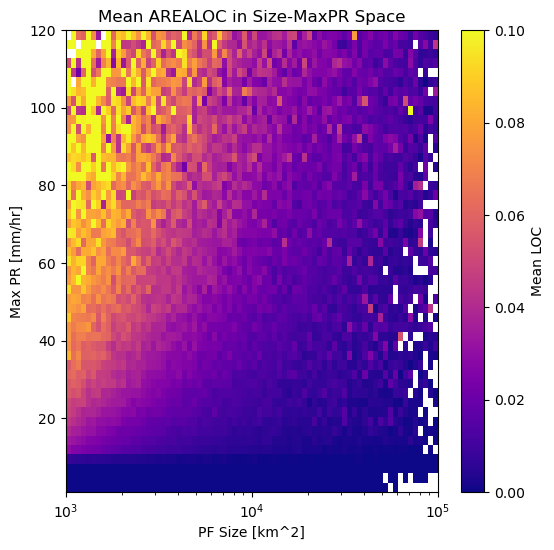

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d

regions = [cio_region(), wmp_region()]

size = np.array([])
loc = np.array([])
max_pr = np.array([])

# Load and concatenate data for all regions
for region in regions:
    pf_stats = load_pf_stats(region, trim_region=True)
    cur_size = pf_stats.num_pixels * 25
    cur_loc = (pf_stats.max_10mmhr_size/pf_stats.num_pixels)
    cur_max_pr = pf_stats.max_precip

    size = np.concatenate((size, cur_size))
    loc = np.concatenate((loc, cur_loc))
    max_pr = np.concatenate((max_pr, cur_max_pr))

fig, ax = plt.subplots(figsize=(6,6))

# Define your bins
size_bins = np.logspace(3, 5, 75)
maxpr_bins = np.linspace(1, 120, 50)

# Compute the 2D bin-mean
statistic, xedges, yedges, binnumber = binned_statistic_2d(
    size, max_pr, loc, 
    statistic='mean', 
    bins=[size_bins, maxpr_bins]
)

# statistic[i, j] is the mean loc value in the bin defined by:
# xedges[i] < size <= xedges[i+1] and yedges[j] < max_pr <= yedges[j+1]

# Plotting the 2D mean loc as a colormesh
X, Y = np.meshgrid(xedges, yedges)
cmap = plt.cm.plasma.copy()
norm = colors.Normalize(vmin=0, vmax=0.1)
pcm = ax.pcolormesh(X, Y, statistic.T, shading='auto', cmap=cmap, norm=norm)

ax.set_xscale('log')
ax.set_xlabel('PF Size [km^2]')
ax.set_ylabel('Max PR [mm/hr]')
ax.set_title('Mean AREALOC in Size-MaxPR Space')

fig.colorbar(pcm, ax=ax, label='Mean LOC')
plt.show()


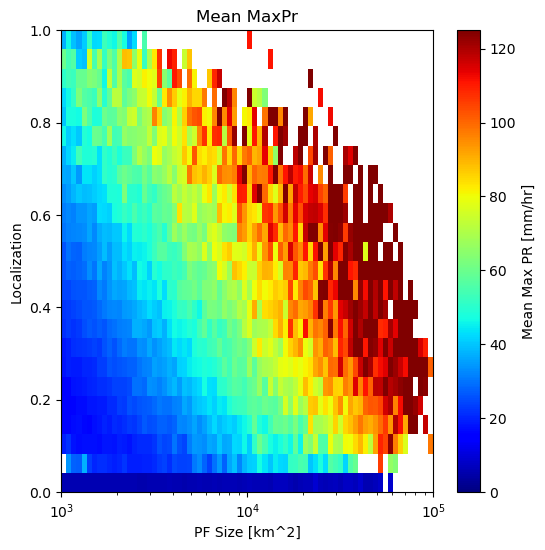

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import binned_statistic_2d

# Assuming cio_region, wmp_region, and load_pf_stats are defined elsewhere
regions = [cio_region(), wmp_region()]

size = np.array([])
loc = np.array([])
max_pr = np.array([])

# Load and concatenate data for all regions
for region in regions:
    pf_stats = load_pf_stats(region, trim_region=True)
    cur_size = pf_stats.num_pixels * 25
    cur_loc = (pf_stats.max_10mmhr_cluster_precip / pf_stats.total_conv_precip)# / (pf_stats.max_10mmhr_size / pf_stats.num_pixels)
    cur_max_pr = pf_stats.max_precip

    size = np.concatenate((size, cur_size))
    loc = np.concatenate((loc, cur_loc))
    max_pr = np.concatenate((max_pr, cur_max_pr))

fig, ax = plt.subplots(figsize=(6,6))

# Define bins for size (x-axis) and loc (y-axis)
size_bins = np.logspace(3, 5, 75)
loc_bins = np.linspace(0, 1, 25)

# Compute the 2D mean max_pr in bins of size (x) and loc (y)
statistic, xedges, yedges, binnumber = binned_statistic_2d(
    size, loc, max_pr,
    statistic=lambda x: np.nanmean(x) if x.size>10 else np.nan,
    bins=[size_bins, loc_bins]
)

# Now xedges correspond to size, yedges correspond to loc
X, Y = np.meshgrid(xedges, yedges)

# Set up a colormap and normalization if desired
cmap = plt.cm.jet.copy()
norm = colors.Normalize(vmin=0, vmax=125)

# Plot the 2D mean max_pr
# Note: statistic[i,j] has i indexing x-bins and j indexing y-bins, so we use statistic.T since 
# meshgrid outputs X and Y in (row, col) format.
pcm = ax.pcolormesh(X, Y, statistic.T, shading='auto', cmap=cmap, norm=norm)

ax.set_xscale('log')
ax.set_xlabel('PF Size [km^2]')
ax.set_ylabel('Localization')
ax.set_title('Mean MaxPr')

fig.colorbar(pcm, ax=ax, label='Mean Max PR [mm/hr]')
plt.show()


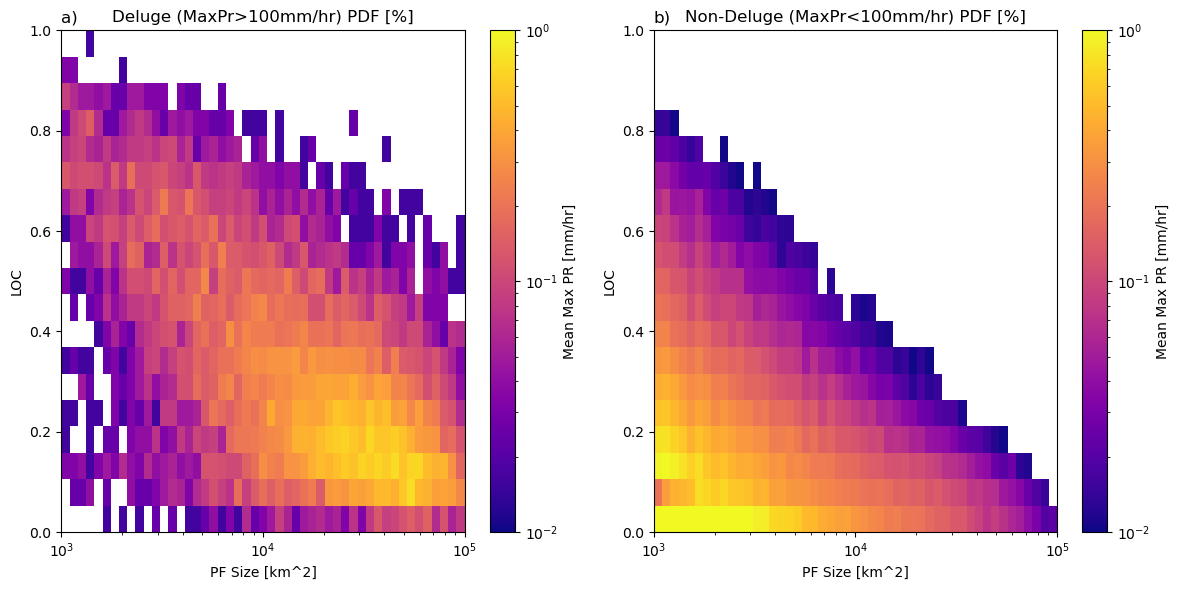

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import binned_statistic_2d

# Assuming cio_region, wmp_region, load_pf_stats, and globe.is_land are defined elsewhere
regions = [cio_region(), wmp_region()]
thresh = 100

epe_size = np.array([])
epe_loc = np.array([])
epe_max_pr = np.array([])

non_epe_size = np.array([])
non_epe_loc = np.array([])
non_epe_max_pr = np.array([])

# Load and concatenate data for all regions
for region in regions:
    pf_stats = load_pf_stats(region, trim_region=True)
    cur_max_pr = pf_stats.max_precip

    # Define EPE and non-EPE masks
    epe_mask = cur_max_pr >= thresh
    non_epe_mask = (cur_max_pr < thresh)

    # Extract subsets
    epe_stats = pf_stats.where(epe_mask).dropna()
    non_epe_stats = pf_stats.where(non_epe_mask).dropna()
    
    # Compute EPE arrays
    epe_cur_size = epe_stats.num_pixels * 25
    epe_cur_loc = (epe_stats.max_10mmhr_cluster_precip / epe_stats.total_precip)
    epe_cur_max_pr = epe_stats.max_precip

    # Compute Non-EPE arrays
    non_epe_cur_size = non_epe_stats.num_pixels * 25
    non_epe_cur_loc = (non_epe_stats.max_10mmhr_cluster_precip / non_epe_stats.total_precip)
    non_epe_cur_max_pr = non_epe_stats.max_precip

    # Concatenate EPE arrays
    epe_size = np.concatenate((epe_size, epe_cur_size))
    epe_loc = np.concatenate((epe_loc, epe_cur_loc))
    epe_max_pr = np.concatenate((epe_max_pr, epe_cur_max_pr))

    # Concatenate Non-EPE arrays
    non_epe_size = np.concatenate((non_epe_size, non_epe_cur_size))
    non_epe_loc = np.concatenate((non_epe_loc, non_epe_cur_loc))
    non_epe_max_pr = np.concatenate((non_epe_max_pr, non_epe_cur_max_pr))

# Define bins
size_bins = np.logspace(3, 5, 50)
loc_bins = np.linspace(0, 1, 20)

# Compute 2D statistics for EPE
statistic_epe, xedges_epe, yedges_epe, binnumber_epe = binned_statistic_2d(
    epe_size, epe_loc, epe_max_pr,
    statistic='count',
    bins=[size_bins, loc_bins]
)

# Compute 2D statistics for Non-EPE
statistic_non_epe, xedges_non_epe, yedges_non_epe, binnumber_non_epe = binned_statistic_2d(
    non_epe_size, non_epe_loc, non_epe_max_pr,
    statistic='count',
    bins=[size_bins, loc_bins]
)

# Plotting
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
cmap = plt.cm.plasma.copy()
cmap.set_under('white')
norm = colors.Normalize(vmin=0.1, vmax=1)
norm = colors.LogNorm(vmin=1e-2, vmax=1e0)
# EPE plot
X_epe, Y_epe = np.meshgrid(xedges_epe, yedges_epe)
pcm_epe = axs[0].pcolormesh(X_epe, Y_epe, 100*statistic_epe.T/statistic_epe.sum(), cmap=cmap, norm=norm)
axs[0].set_xscale('log')
axs[0].set_xlabel('PF Size [km^2]')
axs[0].set_ylabel('LOC')
axs[0].set_title(f'Deluge (MaxPr>{thresh}mm/hr) PDF [%]')
axs[0].set_title(f'a)', loc='left')
fig.colorbar(pcm_epe, ax=axs[0], label='Mean Max PR [mm/hr]')

# Non-EPE plot
X_non_epe, Y_non_epe = np.meshgrid(xedges_non_epe, yedges_non_epe)
pcm_non_epe = axs[1].pcolormesh(X_non_epe, Y_non_epe, 100*statistic_non_epe.T/statistic_non_epe.sum(), cmap=cmap, norm=norm)
axs[1].set_xlabel('PF Size [km^2]')
axs[1].set_ylabel('LOC')
axs[1].set_xscale('log')

axs[1].set_title(f'Non-Deluge (MaxPr<{thresh}mm/hr) PDF [%]')
axs[1].set_title(f'b)', loc='left')
fig.colorbar(pcm_non_epe, ax=axs[1], label='Mean Max PR [mm/hr]')

plt.tight_layout()
plt.show()


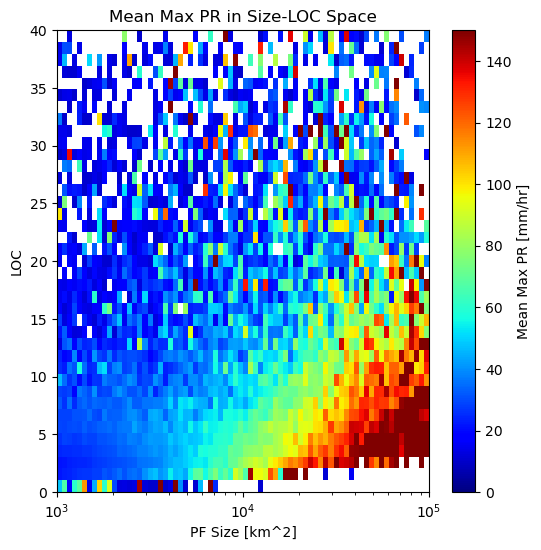

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import binned_statistic_2d

# Assuming cio_region, wmp_region, and load_pf_stats are defined elsewhere
regions = [cio_region(), wmp_region()]

size = np.array([])
loc = np.array([])
max_pr = np.array([])

# Load and concatenate data for all regions
for region in regions:
    pf_stats = load_pf_stats(region, trim_region=True)
    cur_size = pf_stats.num_pixels * 25
    cur_loc = (pf_stats.max_10mmhr_cluster_precip / pf_stats.total_conv_precip) / (pf_stats.max_10mmhr_size / pf_stats.num_2mmhr_pixels)
    cur_max_pr = pf_stats.max_precip

    size = np.concatenate((size, cur_size))
    loc = np.concatenate((loc, cur_loc))
    max_pr = np.concatenate((max_pr, cur_max_pr))

fig, ax = plt.subplots(figsize=(6,6))

# Define bins for size (x-axis) and loc (y-axis)
size_bins = np.logspace(3, 5, 75)
loc_bins = np.linspace(0, 40, 40)

# Compute the 2D mean max_pr in bins of size (x) and loc (y)
statistic, xedges, yedges, binnumber = binned_statistic_2d(
    size, loc, max_pr,
    statistic='mean',
    bins=[size_bins, loc_bins]
)

# Now xedges correspond to size, yedges correspond to loc
X, Y = np.meshgrid(xedges, yedges)

# Set up a colormap and normalization if desired
cmap = plt.cm.jet.copy()
norm = colors.Normalize(vmin=0, vmax=150)

# Plot the 2D mean max_pr
# Note: statistic[i,j] has i indexing x-bins and j indexing y-bins, so we use statistic.T since 
# meshgrid outputs X and Y in (row, col) format.
pcm = ax.pcolormesh(X, Y, statistic.T, shading='auto', cmap=cmap, norm=norm)

ax.set_xscale('log')
ax.set_xlabel('PF Size [km^2]')
ax.set_ylabel('LOC')
ax.set_title('Mean Max PR in Size-LOC Space')

fig.colorbar(pcm, ax=ax, label='Mean Max PR [mm/hr]')
plt.show()
